<a href="https://colab.research.google.com/github/rayoo22/MNIST-ImageClassifier/blob/main/multiclassifier_and_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from google.colab import files
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
uploaded = files.upload()

In [ ]:
uploaded1 = files.upload()

Saving UNSW-NB15_features.csv to UNSW-NB15_features.csv


In [ ]:
spark = SparkSession.builder.appName("UNSW-NB15 Binary Classifier").getOrCreate()

df = spark.read.csv('UNSW-NB15.csv', header=False, inferSchema=True)

In [ ]:
feature_df = spark.read.csv('UNSW-NB15_features.csv', header=True)
feature_df.show(truncate=False)

+---+-------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|No.|Name   |Type   |Description                                                                                                                                                   |
+---+-------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |srcip  |nominal|Source IP address                                                                                                                                             |
|2  |sport  |integer|Source port number                                                                                                                                            |
|3  |dstip  |nominal|Destination IP address                                                    

In [ ]:
feature_names = [row['Name'] for row in feature_df.collect()]

In [ ]:
df = df.toDF(*feature_names)

In [ ]:
df.show(5)

+----------+-----+-------------+------+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+----------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|   Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+---------

In [ ]:
# DATA EXPLORATION AND PREPROCESSING

In [ ]:
# Handle nulls
from pyspark.sql.functions import when, trim

df = df.fillna({'attack_cat': 'Normal'})
df = df.withColumn("attack_cat", trim(col("attack_cat")))

In [ ]:
df = df.withColumnRenamed("ct_src_ ltm", "ct_src_ltm")

In [ ]:
df.show(5)

+----------+-----+-------------+------+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+----------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|   Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+

In [ ]:
df = df.drop("id", "srcip", "sport", "dstip", "dsport", "is_sm_ips_ports")  # Keep only engineered and numeric fields

In [ ]:
df.select("dur", "sbytes", "dbytes", "sttl", "dttl", "Spkts", "Dpkts").describe().show()

+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|               dur|           sbytes|            dbytes|             sttl|              dttl|            Spkts|             Dpkts|
+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|           2539739|          2539739|           2539739|          2539739|           2539739|          2539739|           2539739|
|   mean|0.6588634003800393|4340.072263330996| 36432.01132478574|62.78149802007214|   30.770440978384| 33.2925678583508|42.731821655689814|
| stddev|13.925767633289283|56409.39812286232|161105.30400824756|74.62669956848524|42.851922189518724|76.28775585678378|121.50842004704197|
|    min|               0.0|              0.0|               0.0|              0.0|               0.0|              0.0|               0.0|
|    max|         87

In [ ]:
df.groupBy("attack_cat").count().orderBy("count", ascending=False).show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|        Normal|2218456|
|       Generic| 215481|
|      Exploits|  44525|
|       Fuzzers|  24246|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Analysis|   2677|
|      Backdoor|   1795|
|     Shellcode|   1511|
|     Backdoors|    534|
|         Worms|    174|
+--------------+-------+



In [ ]:
df_sample = df.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

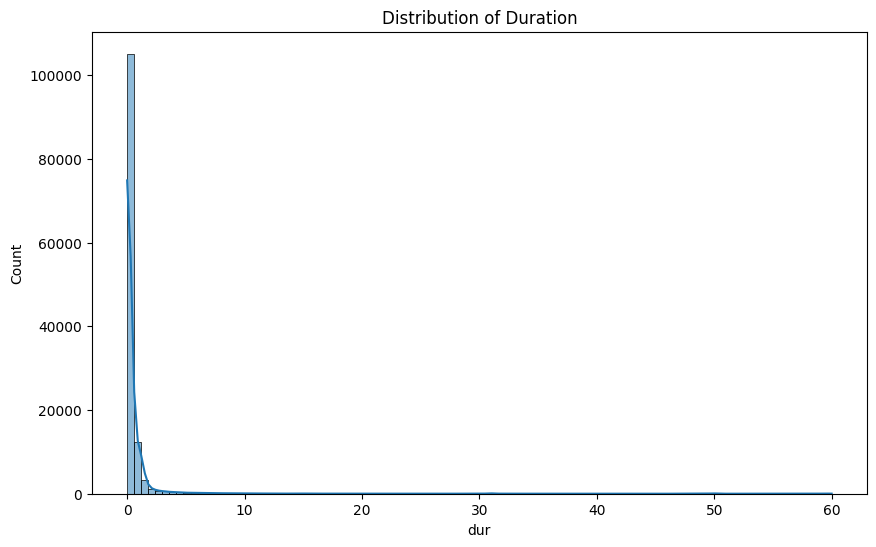

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_sample["dur"], bins=100, kde=True)
plt.title("Distribution of Duration")
plt.show()

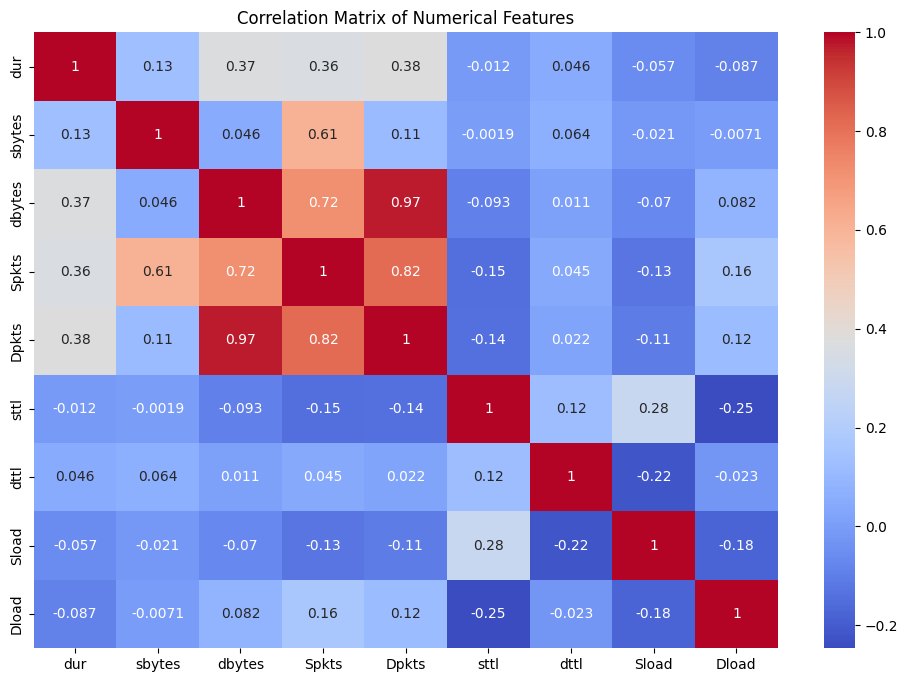

In [ ]:
numeric_cols = ["dur", "sbytes", "dbytes", "Spkts", "Dpkts", "sttl", "dttl", "Sload", "Dload"]
corr_matrix = df_sample[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [ ]:
# cast numerical columns
from pyspark.sql.functions import col

numeric_cols = ["dur", "sbytes", "dbytes", "sttl", "dttl", "Spkts", "Dpkts", "Sload", "Dload", "ct_ftp_cmd", "ct_flw_http_mthd"]
for c in numeric_cols:
    df = df.withColumn(c, col(c).cast("double"))

In [ ]:
# encode categorical columns
from pyspark.ml.feature import StringIndexer

categorical_cols = ["proto", "service", "state", "attack_cat"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]

for indexer in indexers:
    df = indexer.fit(df).transform(df)

In [ ]:
# assembling of features
from pyspark.ml.feature import VectorAssembler

feature_cols = numeric_cols + ["proto_index", "service_index", "state_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [ ]:
# preparing labels for classification
# Binary classification
df_binary = df.withColumn("label", when(df["label"] == 1, 1).otherwise(0))

# Multi-class classification
# 'attack_cat_index' already created by StringIndexer

In [ ]:
from pyspark.sql.functions import rand

# Shuffle the DataFrame
df_shuffled = df_binary.orderBy(rand())

In [ ]:
# train test splitting of the features
train_data, test_data = df_shuffled.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# training the binary classifier
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxBins=150)
rf_model = rf.fit(train_data)

In [ ]:
#make predictions
predictions = rf_model.transform(test_data)
predictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.05907611922349...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04295031029343...|
|    1|       1.0|[0.06606247971519...|
|    1|       1.0|[0.04835895671777...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04490871737569...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04295031029343...|
|    1|       1.0|[0.04295031029343...|
|    1|       1.0|[0.04295031029343...|
|    1|       1.0|[0.04835895671777...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04937924863637...|
|    1|       1.0|[0.04490871737569...|
|    1|       1.0|[0.04295031029343...|
|    1|       1.0|[0.04835895671777...|
|    1|       1.0|[0.04937924863637...|
+-----+----------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC for Binary Classification: {auc}")

AUC for Binary Classification: 0.9991583086877553


In [ ]:
# train and test for the multi classifier

# Shuffle the DataFrame
from pyspark.sql.functions import rand
df_shuffled_2 = df.orderBy(rand())

#run trining validation and testing
train_data_mc, val_data_mc, test_data_mc = df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [ ]:
# train the model (multi) classifier
from pyspark.ml.classification import RandomForestClassifier

rf_mc = RandomForestClassifier(
    labelCol="attack_cat_index",
    featuresCol="features",
    numTrees=100,
    maxBins=150  # ensure this is >= highest cardinality of any categorical feature
)

rf_mc_model = rf_mc.fit(train_data_mc)

In [ ]:
# validate using validation set
val_predictions_mc = rf_mc_model.transform(val_data_mc)

evaluator = MulticlassClassificationEvaluator(
    labelCol="attack_cat_index",
    predictionCol="prediction",
    metricName="accuracy"  # or "f1", "weightedPrecision", "weightedRecall"
)
val_auc = evaluator.evaluate(val_predictions_mc)
print(f"Validation AUC: {val_auc}")

Validation AUC: 0.9715308944195113


In [ ]:
test_predictions_mc = rf_mc_model.transform(test_data_mc)

test_accuracy = evaluator.evaluate(test_predictions_mc)
print(f"Test Accuracy (Multi-class RF): {test_accuracy}")

Test Accuracy (Multi-class RF): 0.9722138558663903


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_mc = MulticlassClassificationEvaluator(
    labelCol="attack_cat_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_mc.evaluate(test_predictions_mc)
print(f"Accuracy for Multi-Class Classification: {accuracy}")


Accuracy for Multi-Class Classification: 0.9722138558663903


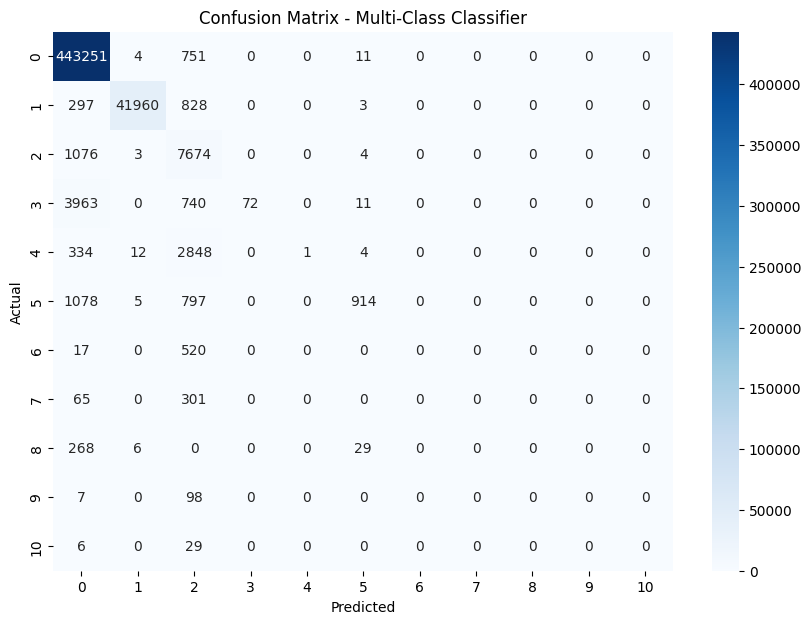

In [ ]:
preds_pd = test_predictions_mc.select("attack_cat_index", "prediction").toPandas()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(preds_pd["attack_cat_index"], preds_pd["prediction"])

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Multi-Class Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(preds_pd["attack_cat_index"], preds_pd["prediction"]))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    665646
         1.0       1.00      0.97      0.99     64500
         2.0       0.57      0.62      0.59     13205
         3.0       1.00      0.02      0.03      7244
         4.0       0.36      0.00      0.00      4862
         5.0       0.00      0.00      0.00      4180
         6.0       0.00      0.00      0.00       814
         7.0       0.00      0.00      0.00       539
         8.0       0.00      0.00      0.00       468
         9.0       0.00      0.00      0.00       163
        10.0       0.00      0.00      0.00        48

    accuracy                           0.97    761669
   macro avg       0.35      0.24      0.24    761669
weighted avg       0.96      0.97      0.96    761669



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    preds_pd["attack_cat_index"],
    preds_pd["prediction"],
    digits=3
))

              precision    recall  f1-score   support

         0.0      0.984     0.998     0.991    444017
         1.0      0.999     0.974     0.986     43088
         2.0      0.526     0.876     0.657      8757
         3.0      1.000     0.015     0.030      4786
         4.0      1.000     0.000     0.001      3199
         5.0      0.936     0.327     0.485      2794
         6.0      0.000     0.000     0.000       537
         7.0      0.000     0.000     0.000       366
         8.0      0.000     0.000     0.000       303
         9.0      0.000     0.000     0.000       105
        10.0      0.000     0.000     0.000        35

    accuracy                          0.972    507987
   macro avg      0.495     0.290     0.286    507987
weighted avg      0.975     0.972     0.964    507987



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


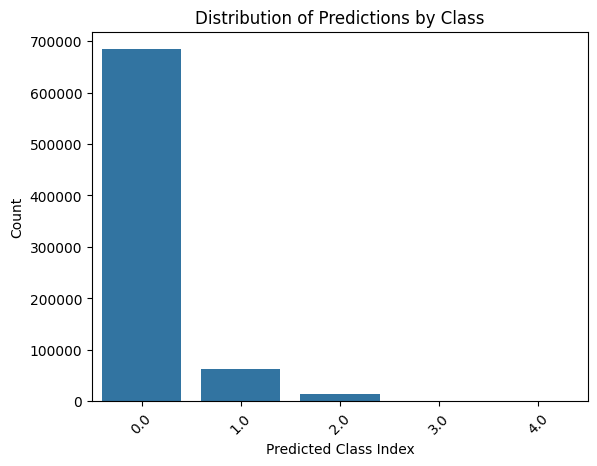

In [ ]:
sns.countplot(x="prediction", data=preds_pd)
plt.title("Distribution of Predictions by Class")
plt.xlabel("Predicted Class Index")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

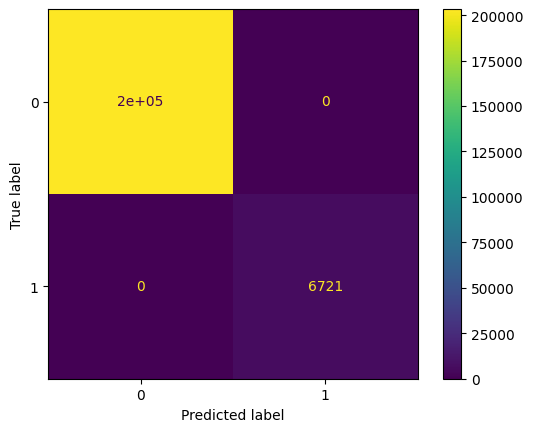

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

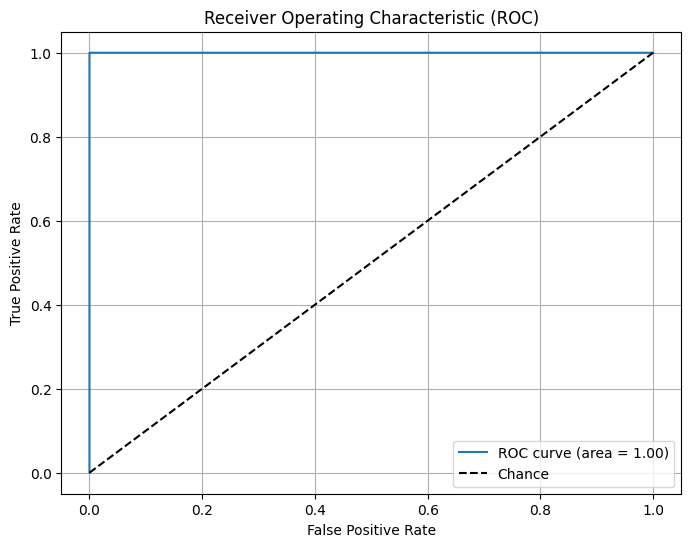

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract the probability of positive class
y_true = predictions_pd['label']
y_score = predictions_pd['probability'].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def get_metrics(predictions):
    tp = predictions.filter((col("prediction") == 1) & (col("label") == 1)).count()
    tn = predictions.filter((col("prediction") == 0) & (col("label") == 0)).count()
    fp = predictions.filter((col("prediction") == 1) & (col("label") == 0)).count()
    fn = predictions.filter((col("prediction") == 0) & (col("label") == 1)).count()

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1


In [ ]:
precision, recall, f1 = get_metrics(predictions)
print(f"Precision = {precision}, Recall = {recall}, F1 = {f1}")

Precision = 1.0, Recall = 1.0, F1 = 1.0


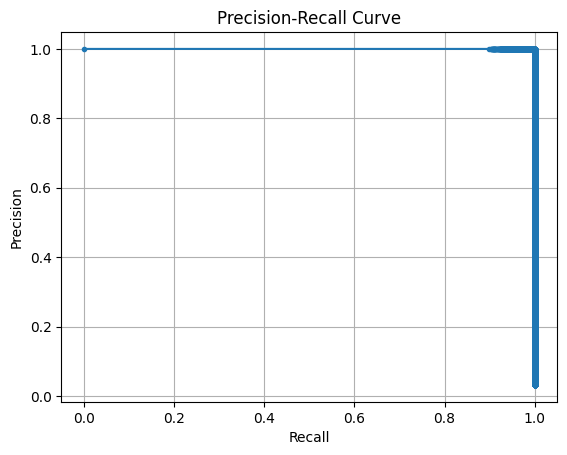

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_score)

plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"  # or "areaUnderPR"
)

auc = evaluator.evaluate(predictions)
print("AUC (ROC) =", auc)


AUC (ROC) = 0.9999975695367608


In [ ]:
#random forest binary classifier
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(
    featuresCol="feature_cols",
    labelCol="label",
    numTrees=100,
    maxDepth=10
)

rf_model = rf.fit(train_data)

NameError: name 'RandomForestClassifier' is not defined